In [37]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [38]:
raw=mne.io.read_raw_gdf('BCICIV_2a_gdf/A01E.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'])
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from C:\Users\HP\Downloads\BCI PROJECT-20220624T090242Z-001\BCI PROJECT\Notebooks\BCI 4\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\Users\HP\miniconda3\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\HP\miniconda3\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01E.gdf, 22 x 687000 (2748.0 s), ~26 kB, data not loaded>

**From the paper**  
'1023': 1 (Rejected trial),   
 '1072': 2 (Eye movements),  
 '276':  3 (eyes open)),  
 '277':  4 (eyes closed),   
 '32766':5 (Start of a new run),  
 '768':  6 (Start of a trial),  
 '769': 7 (class 1),  
 '770': 8 (class 2),  
 '771': 9 (class 3),  
 '772': 10 (class 4)
#### event ids are not same for all subjects

In [39]:
def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events, event_id =mne.events_from_annotations(raw)
    #events[1]['769'],events[1]['770'],events[1]['771'],events[1]['772']
    ann = event_id.keys()
    ann = list(map(int,ann))
    ids = event_id.values()
    ids = list(ids)
    unq = np.unique(events[:,-1])
    for u in unq:
        events[:,-1] = np.where(events[:,-1]== u , ann[u-1],events[:,-1])
    epochs = mne.Epochs(raw, events, event_id=[769,772],
                        tmin= 0, tmax=4,baseline=(None,4), on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [40]:
paths = glob.glob('BCICIV_2a_gdf/*T.gdf')
paths

['BCICIV_2a_gdf\\A01T.gdf',
 'BCICIV_2a_gdf\\A02T.gdf',
 'BCICIV_2a_gdf\\A03T.gdf',
 'BCICIV_2a_gdf\\A04T.gdf',
 'BCICIV_2a_gdf\\A05T.gdf',
 'BCICIV_2a_gdf\\A06T.gdf',
 'BCICIV_2a_gdf\\A07T.gdf',
 'BCICIV_2a_gdf\\A08T.gdf',
 'BCICIV_2a_gdf\\A09T.gdf']

In [41]:
%%capture
features,labels,groups=[],[],[]
for i in paths:
    feature,label=read_data(i)
    features.append(feature)
    labels.append(label)
    groups.append([i]*len(label))

In [42]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((1296, 22, 1001), (1296,), (1296,))

In [43]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array(['BCICIV_2a_gdf\\A01T.gdf', 'BCICIV_2a_gdf\\A02T.gdf',
        'BCICIV_2a_gdf\\A03T.gdf', 'BCICIV_2a_gdf\\A04T.gdf',
        'BCICIV_2a_gdf\\A05T.gdf', 'BCICIV_2a_gdf\\A06T.gdf',
        'BCICIV_2a_gdf\\A07T.gdf', 'BCICIV_2a_gdf\\A08T.gdf',
        'BCICIV_2a_gdf\\A09T.gdf'], dtype='<U22'),
 array([144, 144, 144, 144, 144, 144, 144, 144, 144], dtype=int64))

In [44]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts


(array([769, 772]), array([648, 648], dtype=int64))

# Chronet tensor preparation

In [45]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [46]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [47]:
lb = preprocessing.LabelBinarizer()

#enc_df= enc.fit_transform(dataset['60'])
labels =  lb.fit_transform(labels)

In [48]:
np.unique(labels)

array([0, 1])

In [49]:
data_array = features
label_array = labels
group_array = groups
data_array=np.moveaxis(data_array,1,2)

In [50]:
scaler=StandardScaler3D()
train_features,val_features,train_labels,val_labels = train_test_split(data_array, label_array, test_size=0.25, random_state=42)
train_features=scaler.fit_transform(train_features)
val_features=scaler.transform(val_features)

In [51]:
train_features.shape, train_labels.shape

((972, 1001, 22), (972, 1))

# ChronoNet

In [52]:
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Conv2D,Dropout,BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chro

In [53]:
def block(input, dropout_rate):
    conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
    conv1 = Dropout(dropout_rate)(conv1)
    #conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
    conv2 = Dropout(dropout_rate)(conv2)
    #conv2 = BatchNormalization()(conv2)
    
    conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
    conv3 = Dropout(dropout_rate)(conv3)
    #conv3 = BatchNormalization()(conv3)
    x = concatenate([conv1,conv2,conv3],axis=2)
    return x

In [54]:
input= Input(shape=(train_features.shape[1],train_features.shape[2]))
dropout_rate = 0.5
block1=block(input, dropout_rate)
block2=block(block1, dropout_rate)
block3=block(block2, dropout_rate)
block3.shape

TensorShape([None, 126, 96])

In [55]:
gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

In [56]:
predictions = Dense(train_labels.shape[1] ,activation='sigmoid')(gru_out4)
model = Model(inputs=input, outputs=predictions)

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1001, 22)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 501, 32)      1440        ['input_2[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 501, 32)      2848        ['input_2[0][0]']                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 501, 32)      5664        ['input_2[0][0]']                
                                                                                            

In [58]:
model.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [67]:
chrono_history = model.fit(train_features,train_labels,epochs=10,batch_size=20,validation_data=(val_features,val_labels))

Epoch 1/10
49/49 [==============================] - 22s 453ms/step - loss: 0.1054 - accuracy: 0.9568 - val_loss: 0.7563 - val_accuracy: 0.7500
Epoch 2/10
49/49 [==============================] - 22s 457ms/step - loss: 0.1168 - accuracy: 0.9465 - val_loss: 0.7345 - val_accuracy: 0.7315
Epoch 3/10
49/49 [==============================] - 22s 455ms/step - loss: 0.1096 - accuracy: 0.9568 - val_loss: 0.6518 - val_accuracy: 0.7870
Epoch 4/10
49/49 [==============================] - 23s 463ms/step - loss: 0.0969 - accuracy: 0.9640 - val_loss: 0.6452 - val_accuracy: 0.7809
Epoch 5/10
49/49 [==============================] - 21s 439ms/step - loss: 0.0972 - accuracy: 0.9660 - val_loss: 0.6720 - val_accuracy: 0.7778
Epoch 6/10
49/49 [==============================] - 23s 464ms/step - loss: 0.1065 - accuracy: 0.9630 - val_loss: 0.7110 - val_accuracy: 0.7654
Epoch 7/10
49/49 [==============================] - 23s 463ms/step - loss: 0.1223 - accuracy: 0.9516 - val_loss: 0.6700 - val_accuracy: 0.7716

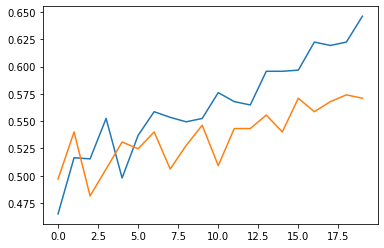

In [25]:
plt.plot(chrono_history.history["accuracy"])
plt.plot(chrono_history.history["val_accuracy"])

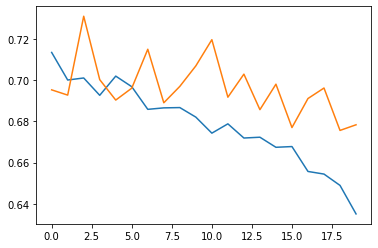

In [26]:
plt.plot(chrono_history.history["loss"])
plt.plot(chrono_history.history["val_loss"])

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       481
           1       0.66      0.73      0.69       491

    accuracy                           0.67       972
   macro avg       0.67      0.67      0.67       972
weighted avg       0.67      0.67      0.67       972



<AxesSubplot:>

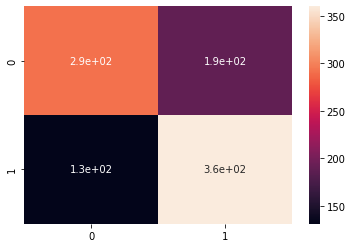

In [27]:
# classification report on training set
y_p = []
pred = model.predict_on_batch(train_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = train_labels.reshape(train_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       167
           1       0.55      0.61      0.58       157

    accuracy                           0.57       324
   macro avg       0.57      0.57      0.57       324
weighted avg       0.57      0.57      0.57       324



<AxesSubplot:>

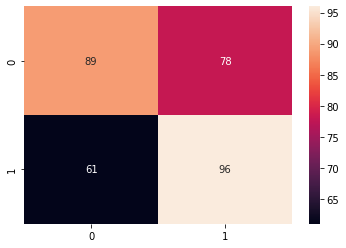

In [28]:
# classification report on validation set
y_p = []
pred = model.predict_on_batch(val_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = val_labels.reshape(val_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

# Multiclass class accuracies

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324



<AxesSubplot:>

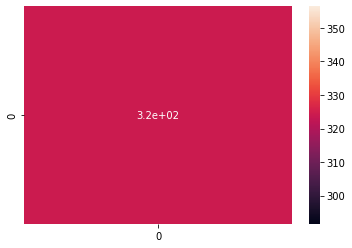

In [30]:
y_t = np.argmax(val_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(val_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       972

    accuracy                           1.00       972
   macro avg       1.00      1.00      1.00       972
weighted avg       1.00      1.00      1.00       972



<AxesSubplot:>

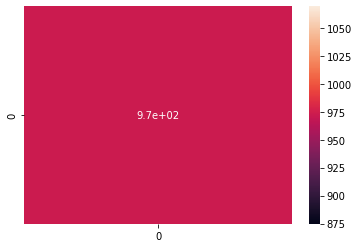

In [31]:
y_t = np.argmax(train_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(train_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

In [32]:
y_p = model.predict_on_batch(val_features)

In [33]:
np.count_nonzero(val_labels)

157

In [34]:
len(val_labels)

324